# GOES observations of electron and proton

Overview of GOES from THEMIS website
<div float="left">
  <img src="http://themis.ssl.berkeley.edu/themisdata/overplots/2021/04/17/goes_goes16_20210417_0024.png" width="45%">
  <img src="http://themis.ssl.berkeley.edu/themisdata/overplots/2021/04/17/goes_goes16_20210417_0006.png" width="45%">
</div>

Particle data is from Space Environment In Situ Suite (SEISS) instrument.

In [9]:
import numpy as np
import pandas as pd
import spacepy.coordinates
import spacepy.irbempy
import spacepy.time
import xarray as xr
from sscws.sscws import SscWs
import pyspedas
from pytplot import get_data, split_vec
from elfin_emics import ax_format_args

In [7]:
def sat_loc_prod(sat, trange, outputs=[], extMag="T01STORM"):
    ssc = SscWs()
    result = ssc.get_locations([sat], trange)  # default is GSE CoordinateSystem

    IRBEM_RE = 6371.2

    data = result["Data"][0]
    time = pd.to_datetime(data["Time"]).tz_convert(None)

    x = data["Coordinates"][0]["X"] / IRBEM_RE
    y = data["Coordinates"][0]["Y"] / IRBEM_RE
    z = data["Coordinates"][0]["Z"] / IRBEM_RE
    coords = np.array([x, y, z]).T

    t = spacepy.time.Ticktock(data["Time"], "ISO")
    loci = spacepy.coordinates.Coords(coords, "GSE", carsph="car", use_irbem=True)
    Lm = spacepy.irbempy.get_Lm(
        t, loci, 90, extMag=extMag
    )  # dict_keys(['Lm', 'Blocal', 'Bmirr', 'Bmin', 'Xj', 'MLT'])

    LShell = xr.DataArray(Lm["Lm"].flatten(), coords=dict(time=time), name="L shell")
    MLT = xr.DataArray(Lm["MLT"].flatten(), coords=dict(time=time), name="MLT")

    return LShell, MLT


# NOTE: slow to load data


def goes_loc_prod(probe, trange, outputs=[], extMag="T01STORM"):
    tvar = f"g{probe}_XYZ_GSE"
    pyspedas.goes.orbit(
        trange=trange,
        probe=probe,
        time_clip=True,
        prefix=f"g{probe}_",
        varformat="XYZ_GSE",
    )
    split_vec(tvar)

    time = get_data(tvar, xarray=True).time
    x = get_data(f"{tvar}_x").y
    y = get_data(f"{tvar}_y").y
    z = get_data(f"{tvar}_z").y
    coords = np.array([x, y, z]).T

    t = spacepy.time.Ticktock(get_data(tvar).times, dtype="UNX")
    loci = spacepy.coordinates.Coords(coords, "GSE", carsph="car", use_irbem=True)
    Lm = spacepy.irbempy.get_Lm(
        t, loci, 90, extMag=extMag
    )  # dict_keys(['Lm', 'Blocal', 'Bmirr', 'Bmin', 'Xj', 'MLT'])

    LShell = xr.DataArray(Lm["Lm"].flatten(), coords=dict(time=time), name="L shell")
    MLT = xr.DataArray(Lm["MLT"].flatten(), coords=dict(time=time), name="MLT")

    return LShell, MLT

In [8]:
# code-summary: utility functions


def format_energy(list):
    return [f"{erg:0.0f} keV" for erg in list]


def calculate_avg_diff_fluxes(trange, probe="16"):
    files = pyspedas.goes.mpsh(trange=trange, probe=probe, downloadonly=True)
    ds = xr.open_mfdataset(files, combine="nested", concat_dim="record_number")
    avg_proton_diff_chans = ds["DiffProtonEffectiveEnergy"].mean(
        dim=["record_number", "telescopes"]
    )
    avg_electron_diff_chans = ds["DiffElectronEffectiveEnergy"].mean(
        dim=["record_number", "telescopes"]
    )
    return avg_proton_diff_chans, avg_electron_diff_chans


def format_flux_data(flux, flux_type, avg_diff_chans, probe):
    """
    Format the flux data.

    Parameters:
    flux : Dataset
        The flux dataset to format.
    flux_type : str
        The type of the flux ('proton' or 'electron').
    avg_diff_chans : DataArray
        The average differential channels.
    probe : str
        The probe used.

    Returns:
    flux_formatted : Dataset
        The formatted flux dataset.
    """
    flux_formatted = flux.rename(
        {
            "v_dim": "telescopes",
            "v2_dim": f"diff_chan_energy",
        }
    ).assign_coords({f"diff_chan_energy": format_energy(avg_diff_chans.values)})
    flux_formatted.attrs["long_name"] = f"{probe} {flux_type.capitalize()}"
    # flux_formatted.attrs['units'] = r'$1/cm^2/s/sr/keV$'
    return flux_formatted


def goes_part_prod(trange, probe="16", flux_type="all"):
    """
    Data products from the GOES satellite.
    """
    # Time-averaged electron fluxes in several differential channels between 50 and 4,000 keV
    # Time-averaged proton fluxes in several differential channels between 80 and 10,000 keV

    avg_proton_diff_chans, avg_electron_diff_chans = calculate_avg_diff_fluxes(
        trange, probe
    )

    pyspedas.goes.mpsh(trange=trange, probe=probe, time_clip=True, prefix=f"g{probe}_")

    flux_data = []
    if flux_type in ["proton", "all"]:
        goes_pflux = get_data(f"g{probe}_AvgDiffProtonFlux", xarray=True)
        goes_pflux = format_flux_data(
            goes_pflux, "proton", avg_proton_diff_chans, f"G{probe}"
        )
        flux_data.append(goes_pflux)

    if flux_type in ["electron", "all"]:
        goes_eflux = get_data(f"g{probe}_AvgDiffElectronFlux", xarray=True)
        goes_eflux = format_flux_data(
            goes_eflux, "electron", avg_electron_diff_chans, f"G{probe}"
        )
        flux_data.append(goes_eflux)

    return tuple(flux_data)


def geos_mag_prod(trange, probe="16"):
    pyspedas.goes.mag(trange=trange, probe=probe, time_clip=True, prefix=f"g{probe}_")

    goes_mag = get_data(f"g{probe}_b_gsm", xarray=True)
    goes_mag.attrs["units"] = "nT"
    goes_mag.attrs["long_name"] = f"G{probe} B"

    goes_mag = goes_mag.assign_coords(v_dim=[r"$B_x$", r"$B_y$", r"$B_z$"])
    return goes_mag

In [ ]:
# | code-summary: Retrieve GOES particle data
# | output: False
trange = ["2021-04-17T00:00:00", "2021-04-17T12:00:00"]

g16_pflux, g16_eflux = goes_part_prod(trange, probe="16")
g17_pflux, g17_eflux = goes_part_prod(trange, probe="17")

g16_mag = geos_mag_prod(trange, probe="16")
g17_mag = geos_mag_prod(trange, probe="17")

# g16_l, g16_mlt = goes_loc_prod("16",trange)
# g17_l, g17_mlt = goes_loc_prod("17",trange)
# g16_l, g16_mlt = sat_loc_prod("goes16", trange) # NOTE: 'L' shell is not smooth
# g17_l, g17_mlt = sat_loc_prod("goes17", trange)
g16_l, g16_mlt = sat_loc_prod("goes16", trange, extMag="T89")
g17_l, g17_mlt = sat_loc_prod("goes17", trange, extMag="T89")
g16_l, g16_mlt = goes_loc_prod("16", trange)
g17_l, g17_mlt = goes_loc_prod("17", trange)
# g16_l, g16_mlt = sat_loc_prod("goes16", trange)
# g17_l, g17_mlt = sat_loc_prod("goes17", trange)

09-Sep-23 12:32:07: Downloading remote index: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l2/data/mpsh-l2-avg1m/2021/04/
09-Sep-23 12:32:08: File is current: /Users/zijin/data/goes/goes16/l2/data/mpsh-l2-avg1m/2021/04/sci_mpsh-l2-avg1m_g16_d20210417_v1-0-3.nc
09-Sep-23 12:32:09: Downloading remote index: https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l2/data/mpsh-l2-avg1m/2021/04/
09-Sep-23 12:32:11: File is current: /Users/zijin/data/goes/goes16/l2/data/mpsh-l2-avg1m/2021/04/sci_mpsh-l2-avg1m_g16_d20210417_v1-0-3.nc
09-Sep-23 12:32:11: Time clip was applied to: g16_L2_SciData_TimeStamp
09-Sep-23 12:32:11: Time clip was applied to: g16_L1bRecordsInAvg
09-Sep-23 12:32:11: Time clip was applied to: g16_YawFlipFlag
09-Sep-23 12:32:11: Time clip was applied to: g16_EclipseFlag
09-Sep-23 12:32:11: Time clip was applied to: g16_AvgDiffProtonFlux
09-Sep-23 12:32:11: Time clip was applied to: g16_AvgDiffProtonFluxUncert
0

In [ ]:
g16_mlt.attrs["long_name"] = "G16 MLT"
g17_mlt.attrs["long_name"] = "G17 MLT"
g16_l.attrs["long_name"] = "G16 L shell"
g17_l.attrs["long_name"] = "G17 L shell"
g16_l, g16_mlt = sat_loc_prod("goes16", trange, extMag="T89")
g17_l, g17_mlt = sat_loc_prod("goes17", trange, extMag="T89")

In [ ]:
pyspedas.tnames()

['GEO_LAT',
 'GEO_LON',
 'GEO_LCT_T',
 'GM_LAT',
 'GM_LON',
 'GM_LCT_T',
 'GSE_LAT',
 'GSE_LON',
 'GSE_LCT_T',
 'GSM_LAT',
 'GSM_LON',
 'SM_LAT',
 'SM_LON',
 'SM_LCT_T',
 'NorthBtrace_GEO_LAT',
 'NorthBtrace_GEO_LON',
 'NorthBtrace_GEO_ARCLEN',
 'SouthBtrace_GEO_LAT',
 'SouthBtrace_GEO_LON',
 'SouthBtrace_GEO_ARCLEN',
 'NorthBtrace_GM_LAT',
 'NorthBtrace_GM_LON',
 'NorthBtrace_GM_ARCLEN',
 'SouthBtrace_GM_LAT',
 'SouthBtrace_GM_LON',
 'SouthBtrace_GM_ARCLEN',
 'RADIUS',
 'MAG_STRTH',
 'DNEUTS',
 'BOW_SHOCK',
 'MAG_PAUSE',
 'L_VALUE',
 'INVAR_LAT',
 'MAG_X',
 'MAG_Y',
 'MAG_Z',
 'XYZ_GEO',
 'XYZ_GM',
 'XYZ_GSE',
 'XYZ_GSM',
 'XYZ_SM',
 'g16_L2_SciData_TimeStamp',
 'g16_L1bRecordsInAvg',
 'g16_YawFlipFlag',
 'g16_EclipseFlag',
 'g16_AvgDiffProtonFlux',
 'g16_AvgDiffProtonFluxUncert',
 'g16_DiffProtonValidL1bSamplesInAvg',
 'g16_DiffProtonDQFdtcSum',
 'g16_DiffProtonDQFoobSum',
 'g16_DiffProtonDQFerrSum',
 'g16_AvgDiffElectronFlux',
 'g16_AvgDiffElectronFluxUncert',
 'g16_DiffElectronVali

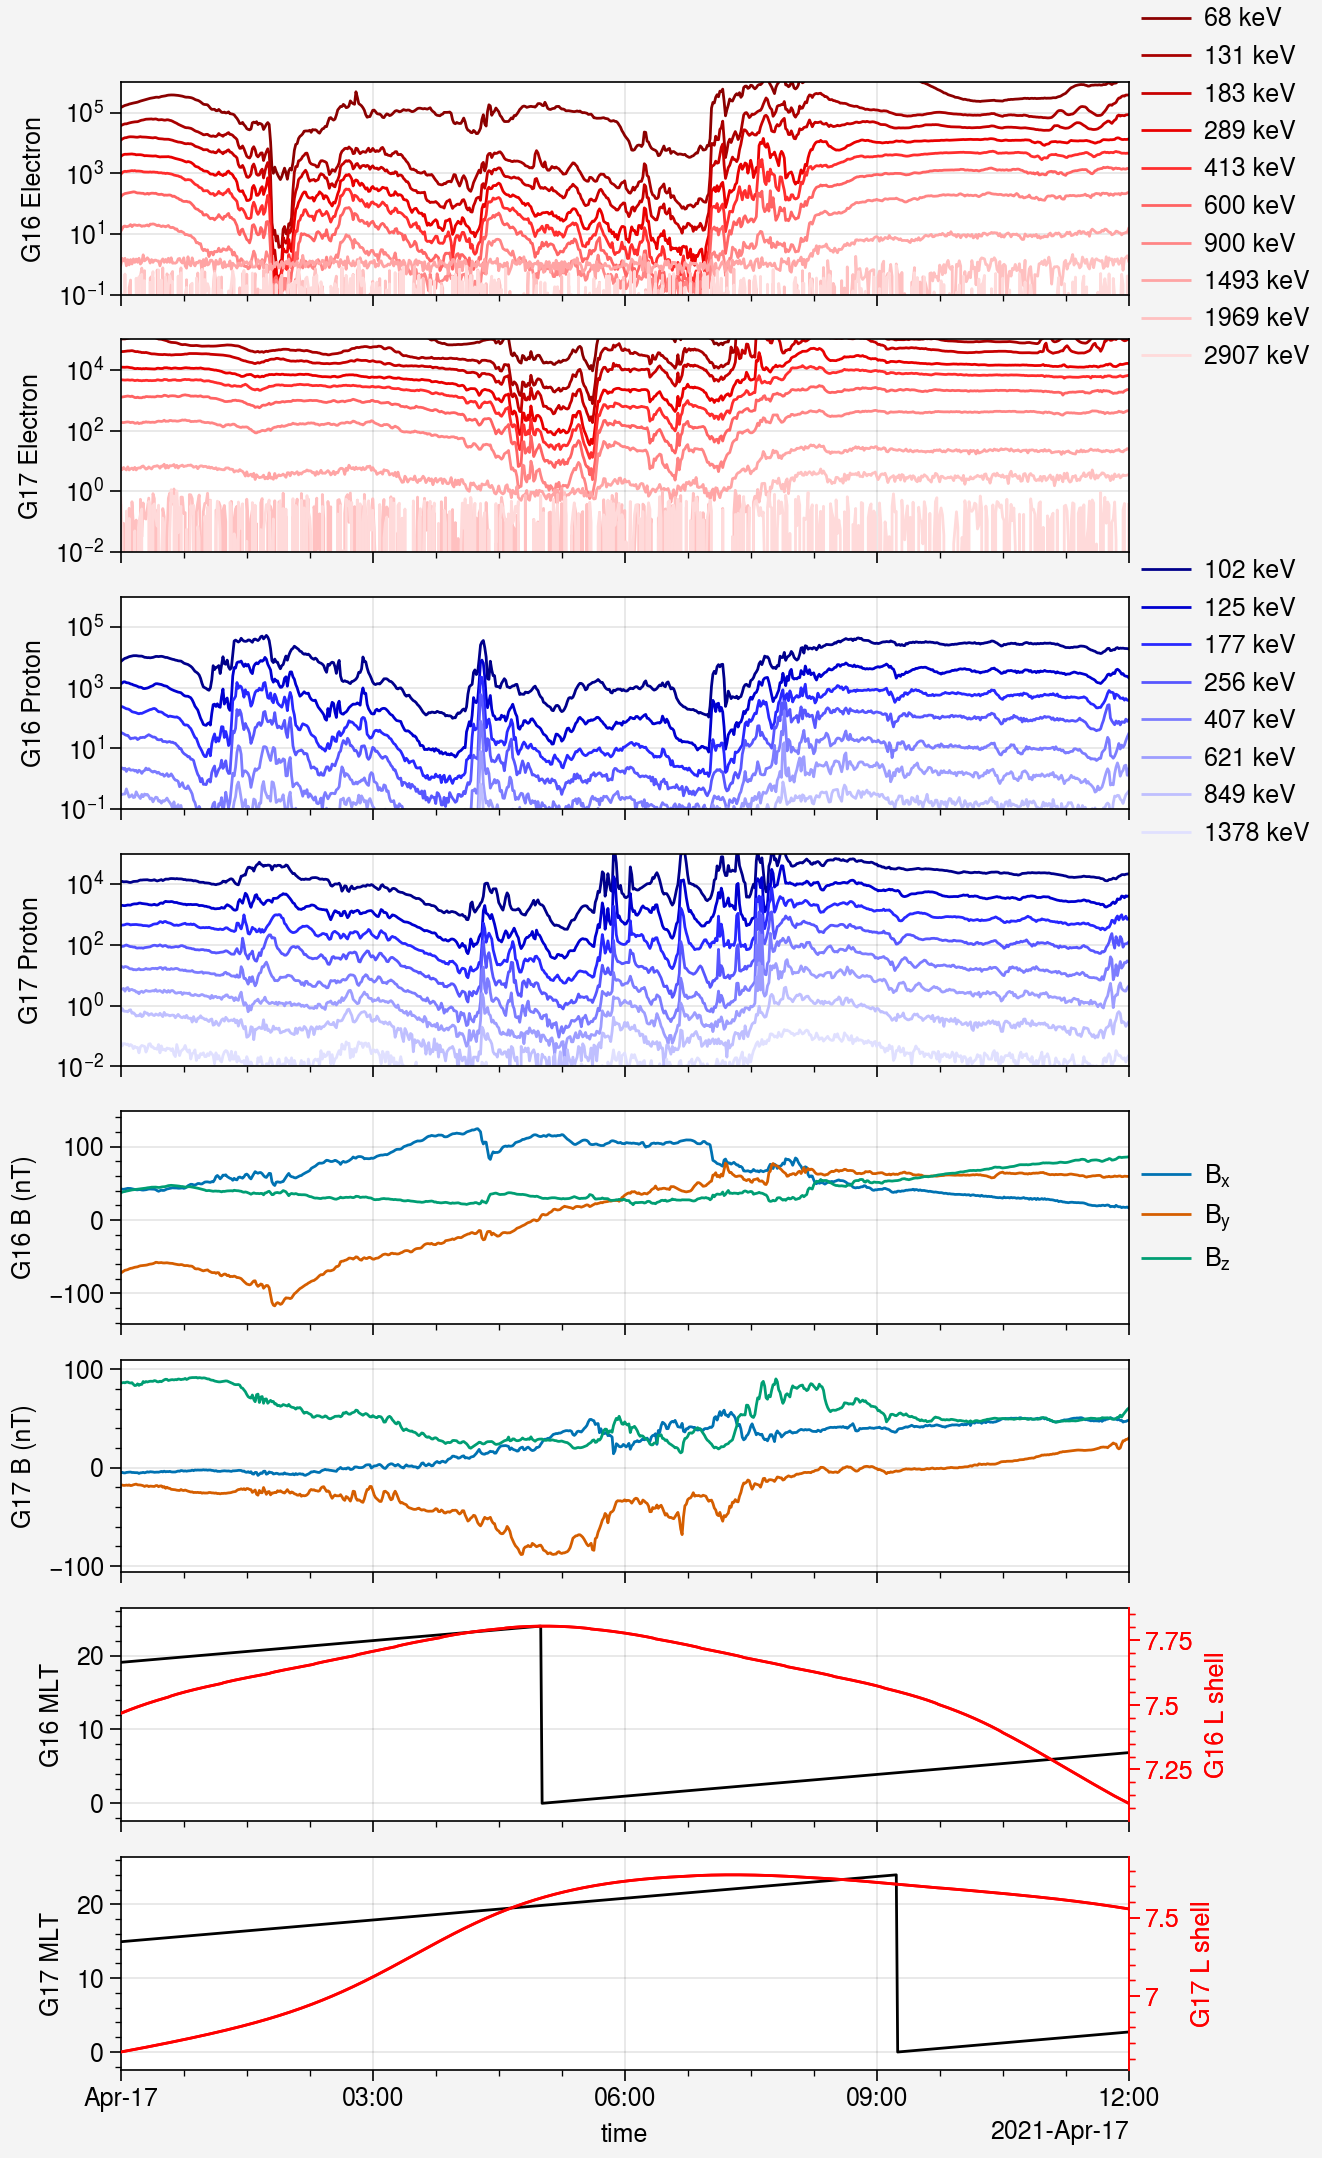

In [ ]:
# | code-summary: Plot GOES electron and proton observations
# | fig-cap: "GOES-R electron and proton observations (70 keV to ~1 MeV) from two geostationary operatioinal satellites. Ion injections are visible before the time when ELFIN observed strong electron precipitation. Series of strong electron injections observed around noon after drifting from the midnight."

# Function to filter data based on energy limits


def filter_data(data, energy_limits):
    summed_data = data.sum(dim="telescopes")
    mask = (summed_data > energy_limits[0]) & (summed_data < energy_limits[1])
    return summed_data.sel(diff_chan_energy=mask.any(dim="time"))


def plot_goes_mpsh(plot_type="paper", save=False):
    match plot_type:
        case "paper":
            fname = "goes_mpsh"
            n = 8
        case "poster":
            fname = "goes_mpsh_poster"
            n = 4


def plot_goes_mpsh(type="paper", save=False):
    fname = "goes_mpsh"
    if type == "poster":
        n = 4
        fname = f"{fname}_poster"
    else:
        n = 7

    fig, axs = pplt.subplots(
        ncols=1,
        nrows=n,
        refwidth=tplot_refwidth,
        refheight=tplot_refheight,
        sharey=False,
    )

    eflux_ylim = (1e-1, 1e6)
    pflux_ylim = (1e-2, 1e5)

    # Filter data
    filtered_g16_eflux = filter_data(g16_eflux, eflux_ylim)
    filtered_g16_pflux = filter_data(g16_pflux, pflux_ylim)
    filtered_g17_eflux = filter_data(g17_eflux, eflux_ylim)
    filtered_g17_pflux = filter_data(g17_pflux, pflux_ylim)

    axs[0].plot(
        filtered_g16_eflux,
        cycle="darkred_r",
    )
    axs[1].plot(
        filtered_g17_eflux,
        cycle="darkred_r",
    )
    axs[2].plot(
        filtered_g16_pflux,
        cycle="darkblue_r",
    )
    axs[3].plot(
        filtered_g17_pflux,
        cycle="darkblue_r",
    )

    format_args = {"yscale": "log", "yformatter": "log"}
    axs[0].format(ylim=eflux_ylim, **format_args)
    axs[1].format(ylim=pflux_ylim, **format_args)
    axs[2].format(ylim=eflux_ylim, **format_args)
    axs[3].format(ylim=pflux_ylim, **format_args)

    axs.format(**ax_format_args)

    # Add legends to axes
    for ax in axs[:4:2]:
        ax.legend(loc="right", ncols=1, frame=False)

    if plot_type != "poster":
        hs = axs[4].plot(g16_mag)
        axs[5].plot(g17_mag)
        axs[6].plot(g16_mlt, color="black", label="G16 MLT")
        # axs[6].plot(g17_mlt, color="black", label="G17 MLT", ls="--")
        temp_ax1 = axs[6].alty(label=g16_l.long_name, color="red")
        temp_ax1.plot(g16_l, color="red", label="G16 L")

        axs[7].plot(g17_mlt, color="black", label="G17 MLT")
        temp_ax2 = axs[7].alty(label=g17_l.long_name, color="red")
        temp_ax2.plot(g17_l, color="red", label="G17 L")

        axs[4].legend(loc="right", ncols=1, frame=False)
        # axs[6].legend(loc="right", ncols=1, frame=False)

        temp_ax1.format(**ax_format_args)
        temp_ax2.format(**ax_format_args)
        axs[6].plot(g17_mlt, color="black", label="G17 MLT", ls="--")
        temp_ax = axs[6].alty(
            label="L shell",
            color="red",
        )
        temp_ax.plot(g16_l, color="red", label="G16 L")
        temp_ax.plot(g17_l, color="red", label="G17 L", ls="--")

        axs[4].legend(loc="right", ncols=1, frame=False)
        axs[5].legend(loc="right", ncols=1, frame=False)
        axs[6].legend(loc="right", ncols=1, frame=False)

    if save:
        fig.savefig(f"../figures/{fname}.svg")
        fig.savefig(f"../figures/{fname}.pdf")

    return fig


# fig = plot_goes_mpsh()
fig = plot_goes_mpsh(save=True)
# fig = plot_goes_mpsh(plot_type='poster', save=True)

# fig = plot_goes_mpsh(type='poster', save=True)
# fig = plot_goes_mpsh(save=True)
fig = plot_goes_mpsh()